In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from importlib import reload

import os
import sys
import re
import glob
import time
import pickle
import scipy.ndimage as ndi
from itertools import islice
import IPython
import logging
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchmore import layers, flex
#import torchtrainers as tt
from torch.utils.data import DataLoader
from webdataset import WebDataset, WebLoader
from ocropus4train import ocrhelpers as helpers
from ocropus4train import ocrmodels2 as models
from ocropus4train.ocrhelpers import method, asnp
import matplotlib.pyplot as plt
from random import randrange
import imageio.v2 as imageio
import gzip
from ocropus4train import nlbin

plt.rc("image", cmap="gray")
plt.rc("image", interpolation="nearest")

def RUN(x): print(x, ":", os.popen(x).read().strip())
    
RUN("date"); RUN("hostname"); RUN("nvidia-smi -L"); RUN("pwd")

if "GOPEN_VERBOSE" in os.environ:
    del os.environ["GOPEN_VERBOSE"]


date : Sat May  6 01:32:18 AM PDT 2023
hostname : baldr
nvidia-smi -L : GPU 0: NVIDIA TITAN V (UUID: GPU-d4e8727f-83eb-5631-119d-1e89b6f6ce55)
GPU 1: NVIDIA TITAN V (UUID: GPU-11093101-e490-ab44-264e-65fbcfa3d823)
pwd : /home/tmb/proj/ocropus4train


In [3]:
training_urls = "gs://ocro-iaa/segs/books-{000000..000653}-segs.tar"
batch_size = 4
mname = "seg_unet_v3"

In [4]:
from ocropus4train.ocraugment import maybe, normalize, noisify, threshold, distort

def random_patch(images, orders, size=512):
    h, w = images[0].shape[:2]
    for image in images:
        assert image.shape[:2] == (h, w)
    matrix = np.eye(3)
    matrix[:2, :2] += np.random.randn(2, 2) * 0.03
    # pick the translation so that we get a patch from anywhere within the image
    matrix[0, 2] = -random.uniform(-size/2, h - size/2)
    matrix[1, 2] = -random.uniform(-size/2, w - size/2)
    # compute the transform from the image to the patch
    matrix = np.linalg.inv(matrix)
    # apply the affine transform
    patches = []
    for image, order in zip(images, orders):
        patch = ndi.affine_transform(image, matrix, output_shape=(size, size), order=order, mode="constant", cval=0)
        patches.append(patch)
    return patches

def random_patch_simple(images, size=512):
    h, w = images[0].shape[:2]
    for image in images:
        assert image.shape[:2] == (h, w)
    y = randrange(0, h - size)
    x = randrange(0, w - size)
    patches = []
    for image in images:
        patches.append(image[y : y + size, x : x + size])
    return patches

def get_patches(sample, size=512):
    global last_img, last_seg
    image1 = sample["jpg"]
    assert image1.ndim == 2
    image1 = image1.astype(np.float32) / 255.0
    if maybe(0.1): # FIXME only for testing
        binarized = nlbin.nlbin(image1)
        if maybe(0.2):
            binarized = (binarized > 0.5).astype(np.float32)
        # binarization sometimes changes image size slightly
        assert np.amax(np.abs(np.array(binarized.shape) - np.array(image1.shape))) <= 2
        # use ndi.affine_transform to make binarized exactly the same shape as image1
        image1 = ndi.affine_transform(binarized, np.eye(3), output_shape=image1.shape, order=0, mode="nearest")
    seg1 = sample["words.jpg"].clip(0, 3)
    mask = ndi.maximum_filter(seg1 == 1, 12)
    seg1 = np.maximum(seg1, mask)
    assert seg1.ndim == 2
    if np.amax(seg1) < 3:
        return
    if image1.shape[0] < size or image1.shape[1] < size:
        return
    for i in range(32):
        # TODO: add 90 degree rotations to augmentations
        # TODO: do something about isolated characters
        last_img, last_seg = img, seg = random_patch([image1, seg1], [1, 0], size=size)
        if maybe(0.05):
            img = threshold(img)
        if maybe(0.5):
            img = distort(img)
        if maybe(0.5):
            img = normalize(img)
        if maybe(0.5):
            img = noisify(img)
        if maybe(0.1):
            sigma = random.uniform(0.5, 2.0)
            img = ndi.gaussian_filter(img, sigma)
        if np.amax(seg) < 3:
            continue
        yield (img, seg)

In [5]:
def expand_patches(src):
    for patch in src:
        for result in get_patches(patch):
            yield result

def usm_patch(img):
    img = img - ndi.gaussian_filter(img, 16.0, mode="nearest")
    return img

def img_tensor(img):
    assert img.ndim == 2, img.shape
    assert img.dtype == np.float32, img.dtype
    assert np.amax(img) < 10.0  # make sure it already got normalied somewhere
    return torch.tensor(img).unsqueeze(0)

def label_tensor(label):
    assert label.ndim == 2, label.shape
    assert label.dtype == np.uint8, label.dtype
    assert np.amax(label) < 4
    return torch.tensor(label).long()

def pipeline(ds):
    return ds.decode("l8").compose(expand_patches).map_tuple(usm_patch).map_tuple(img_tensor, label_tensor)

training = pipeline(WebDataset(training_urls, resampled=True).shuffle(1000)).shuffle(1000).batched(batch_size)
training_dl = WebLoader(training, batch_size=None, num_workers=4, pin_memory=True).with_epoch(10000//batch_size)

In [6]:
device = "cuda:0"
model = models.make(mname)
model.to(device);
model

PixSegmenter(
  (model): Sequential(
    (0): SegInput()
    (1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Shortcut1(
        (f): Sequential(
          (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (1): Conv2d(64, 107, kernel_size=(3, 3), stri

In [7]:
trainer = helpers.SegTrainer(model, masked=-1, device=device)
trainer.load_best()

no load file found


False

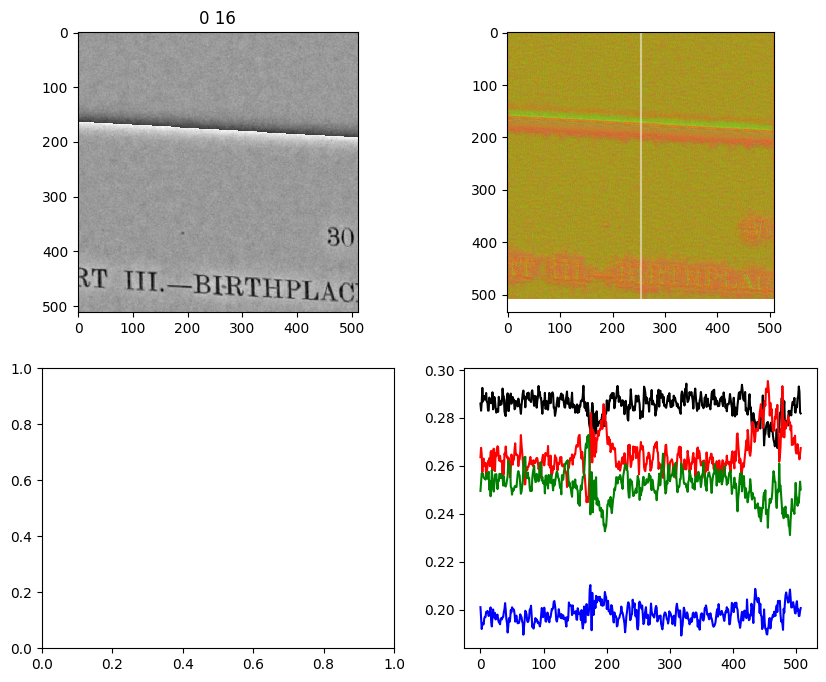

In [8]:
trainer.train(training_dl, learning_rates=[1e-3]+[1e-4]*200, every=10)